In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import random
import seaborn as sns
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

# %matplotlib notebook
%matplotlib inline

In [2]:
import cached

from importlib import reload

reload(cached)

sim = cached.sim

In [3]:
def set_seed(i):
    random.seed(i)
    np.random.seed(random.getrandbits(32))

In [4]:
def draw(G, size="compute", layout=None):
    size = dict(G.nodes(data=size)).values()
    size = np.array(list(size)) * 1000
    size = np.interp(size, (size.min(), size.max()), (100, 2000))
    return_layout = False
    if not layout:
        layout = nx.spring_layout(G, weight="spring_weight")
        return_layout = True
    nx.draw(G, pos=layout, node_size=size)
    if return_layout:
        return layout


def print_(G):
    for l in nx.generate_graphml(G):
        print(l)

compute 6 [0.04761905 0.0952381  0.14285714 0.19047619 0.23809524 0.28571429]


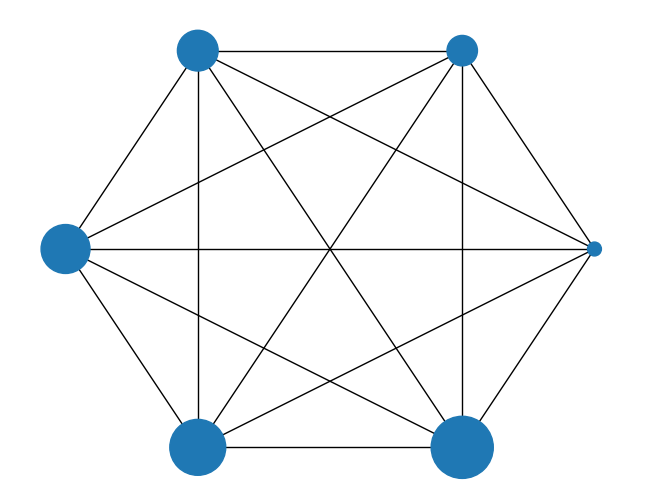

In [5]:
# Mining statistics for the last 7 days before Dec. 12 2022
# from https://www.blockchain.com/explorer/charts/pools
compute = [  # relative hash-rate # blocks mined / pool
    0.24817,  # 271 / Foundry USA
    0.20147,  # 220 / AntPool
    0.15110,  # 165 / F2Pool
    0.13736,  # 150 / Binance Pool
    0.10440,  # 114 / ViaBTC
    0.05311,  # 58  / Braiins Pool
    0.02473,  # 27  / Poolin
    0.01923,  # 21  / BTC.com
    0.01648,  # 18  / Luxor
    0.01465,  # 16  / Mara Pool
    0.00641,  # 7   / Ultimus
    0.00641,  # 7   / SBI Crypto
    0.00366,  # 4   / BTC M4
    0.00275,  # 3   / Titan
    # NaN    # 11  / Unknown
]
assert np.sum(compute) < 1
compute.append(1 - np.sum(compute))

compute = list(range(1, 8))

# compute = [ 0.01, 0.99 ]

compute = compute / np.sum(compute)
print("compute", len(compute), compute)

G = nx.complete_graph(len(compute))
G.graph["dissemination"] = "simple"

for i in range(len(compute)):
    G.nodes[i]["compute"] = compute[i]

for a, b in G.edges:
    # G.edges[a, b]["delay"] = f"uniform 0.5 1.5"
    G.edges[a, b]["delay"] = f"constant 1"

layout = nx.circular_layout(G)
draw(G, layout=layout)
# print_(G)

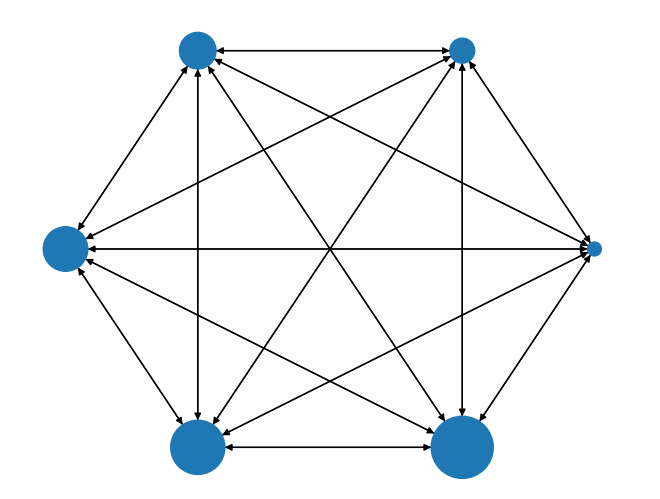

In [6]:
res = sim(G, activation_delay=1, activations=10000, protocol="nakamoto")
draw(res, size="reward", layout=layout)

In [7]:
# copied from https://stackoverflow.com/a/39513799
def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad / np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [8]:
def subblock_selection(x):
    if x.k <= 32:
        return "heuristic"
    else:
        return "altruistic"


families = dict(
    nakamoto=lambda x: "nakamoto",
    bk=lambda x: f"bk-{x.k}-constant",
    bkll=lambda x: f"bkll-{x.k}-constant",
    tailstorm=lambda x: f"tailstorm-{x.k}-{x.scheme}-{subblock_selection(x)}",
    tailstormll=lambda x: f"tailstormll-{x.k}-{x.scheme}-{subblock_selection(x)}",
)

ks = dict(
    nakamoto=[1],
    bk=[2, 4, 8, 16, 32, 64, 128],
    bkll=[2, 4, 8, 16, 32, 64, 128],
    tailstorm=[2, 4, 8, 16, 32, 64, 128],
    tailstormll=[2, 4, 8, 16, 32, 64, 128],
)

schemes = dict(
    nakamoto=["constant"],
    bk=["constant"],
    bkll=["constant"],
    tailstorm=["constant", "discount"],
    tailstormll=["constant", "discount"],
)

block_intervals = [
    1,
    2,
    4,
    8,
    16,
    32,
    64,
    128,
]  # nakamoto/tailstorm/bk blocks, tailstorm summaries (multiples of expected message delay)


def rows():
    for i in range(256):
        for f in families.keys():
            for s in schemes[f]:
                for k in ks[f]:
                    for bi in block_intervals:
                        ad = bi / k  # activation delay
                        if ad >= 1:
                            yield pd.Series(
                                dict(
                                    family=f,
                                    k=k,
                                    scheme=s,
                                    protocol=f"{f}-{k}-{s}",
                                    block_interval=bi,
                                    activation_delay=ad,
                                    seed=i,
                                    activations=1024,
                                    # activations= k * 128, # enough pow for 128 blocks
                                )
                            )


def read(G, field):
    return np.array([G.nodes[i][field] for i in range(len(compute))])


def measure(x):
    res = sim(
        G,
        activation_delay=x.activation_delay,
        activations=x.activations,
        protocol=families[x.family](x),
        seed=x.seed,
    )
    reward = read(res, "reward")
    activations = read(res, "activations")
    assert sum(activations) == x.activations
    compute = read(res, "compute")
    compute = compute / np.sum(compute)
    relrew = reward / np.sum(reward)
    relrewn = relrew / compute
    efficiency0 = reward / compute
    with np.errstate(divide="ignore", invalid="ignore"):
        efficiency1 = np.where(activations > 0, reward / activations, 0.0)
    weakest = np.argmin(compute)
    strongest = np.argmax(compute)
    return pd.Series(
        dict(
            chain_time=res.graph["chain_time"],
            progress=res.graph["progress"],
            height=res.graph["progress"] / x.k,
            reward=np.sum(reward),
            revenue_loss=1 - (np.sum(reward) / np.sum(activations)),
            weakest_reward=reward[weakest],
            weakest_relrew=relrew[weakest],
            weakest_relrewn=relrewn[weakest],
            weakest_efficiency0=efficiency0[weakest],
            weakest_efficiency1=efficiency1[weakest],
            strongest_reward=reward[strongest],
            strongest_relrew=relrew[strongest],
            strongest_relrewn=relrewn[strongest],
            strongest_efficiency0=efficiency0[strongest],
            strongest_efficiency1=efficiency1[strongest],
            diff_reward=reward[strongest] - reward[weakest],
            diff_relrew=relrew[strongest] - relrew[weakest],
            diff_relrewn=relrewn[strongest] - relrewn[weakest],
            diff_efficiency0=efficiency0[strongest] - efficiency0[weakest],
            diff_efficiency1=efficiency1[strongest] - efficiency1[weakest],
            gini_reward=gini(reward),
            gini_relrew=gini(relrew),
            gini_relrewn=gini(relrewn),
            gini_efficiency0=gini(efficiency0),
            gini_efficiency1=gini(efficiency1),
        )
    )


def parallel_measure(df, fun=measure, n_jobs=-1):
    res = Parallel(n_jobs=n_jobs)(
        delayed(measure)(row) for idx, row in tqdm(df.iterrows(), total=len(df))
    )
    return pd.concat([df, pd.DataFrame(res)], axis=1)


df = pd.DataFrame(rows())
df = parallel_measure(df)
df

  0%|          | 0/45056 [00:00<?, ?it/s]

,family,k,scheme,protocol,block_interval,activation_delay,seed,activations,chain_time,progress,...,diff_reward,diff_relrew,diff_relrewn,diff_efficiency0,diff_efficiency1,gini_reward,gini_relrew,gini_relrewn,gini_efficiency0,gini_efficiency1
0,nakamoto,1,constant,nakamoto-1-constant,1,1.0,0,1024,1088.932863,635.0,...,219.000000,0.344882,0.711024,451.500000,0.279087,0.368766,0.368766,0.124814,0.124814,0.083893
1,nakamoto,1,constant,nakamoto-1-constant,2,2.0,0,1024,2177.865725,768.0,...,238.000000,0.309896,0.423828,325.500000,0.090785,0.332899,0.332899,0.066675,0.066675,0.036211
2,nakamoto,1,constant,nakamoto-1-constant,4,4.0,0,1024,4355.731451,879.0,...,251.000000,0.285552,0.302617,266.000000,-0.003686,0.322146,0.322146,0.054676,0.054676,0.030968
3,nakamoto,1,constant,nakamoto-1-constant,8,8.0,0,1024,8711.462902,944.0,...,263.000000,0.278602,0.289195,273.000000,-0.011218,0.310734,0.310734,0.045153,0.045153,0.013208
4,nakamoto,1,constant,nakamoto-1-constant,16,16.0,0,1024,17422.925803,983.0,...,272.000000,0.276704,0.309766,304.500000,0.016907,0.308410,0.308410,0.048592,0.048592,0.005466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45051,tailstormll,32,discount,tailstormll-32-discount,64,2.0,255,1024,2021.714034,992.0,...,183.437500,0.245237,0.122828,91.875000,0.021385,0.293115,0.293115,0.039321,0.039321,0.010970
45052,tailstormll,32,discount,tailstormll-32-discount,128,4.0,255,1024,3991.710057,992.0,...,210.187500,0.248449,0.118425,100.187500,0.018894,0.291888,0.291888,0.030438,0.030438,0.007792
45053,tailstormll,64,discount,tailstormll-64-discount,64,1.0,255,1024,981.714392,960.0,...,146.390625,0.248120,0.112526,66.390625,0.009423,0.292920,0.292920,0.029997,0.029997,0.010400
45054,tailstormll,64,discount,tailstormll-64-discount,128,2.0,255,1024,1953.774544,960.0,...,179.343750,0.248055,0.122385,88.484375,0.019429,0.291018,0.291018,0.029784,0.029784,0.006807


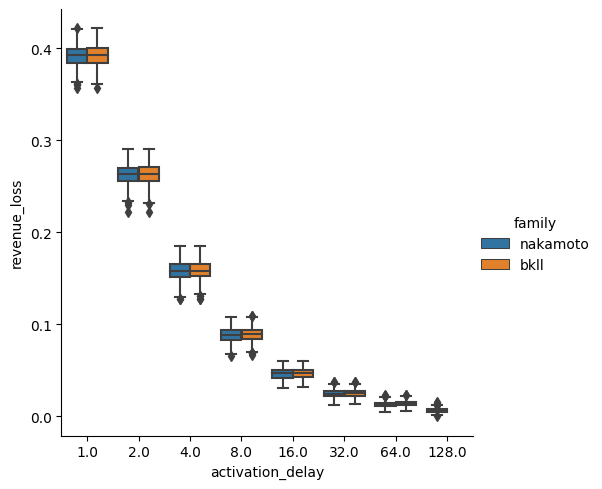

In [9]:
# check: nakamoto = bk_ll 2
ax = sns.catplot(
    data=df.query('family in ["nakamoto", "bkll"] and k in [1, 2]'),
    y="revenue_loss",
    x="activation_delay",
    hue="family",
    kind="box",
)

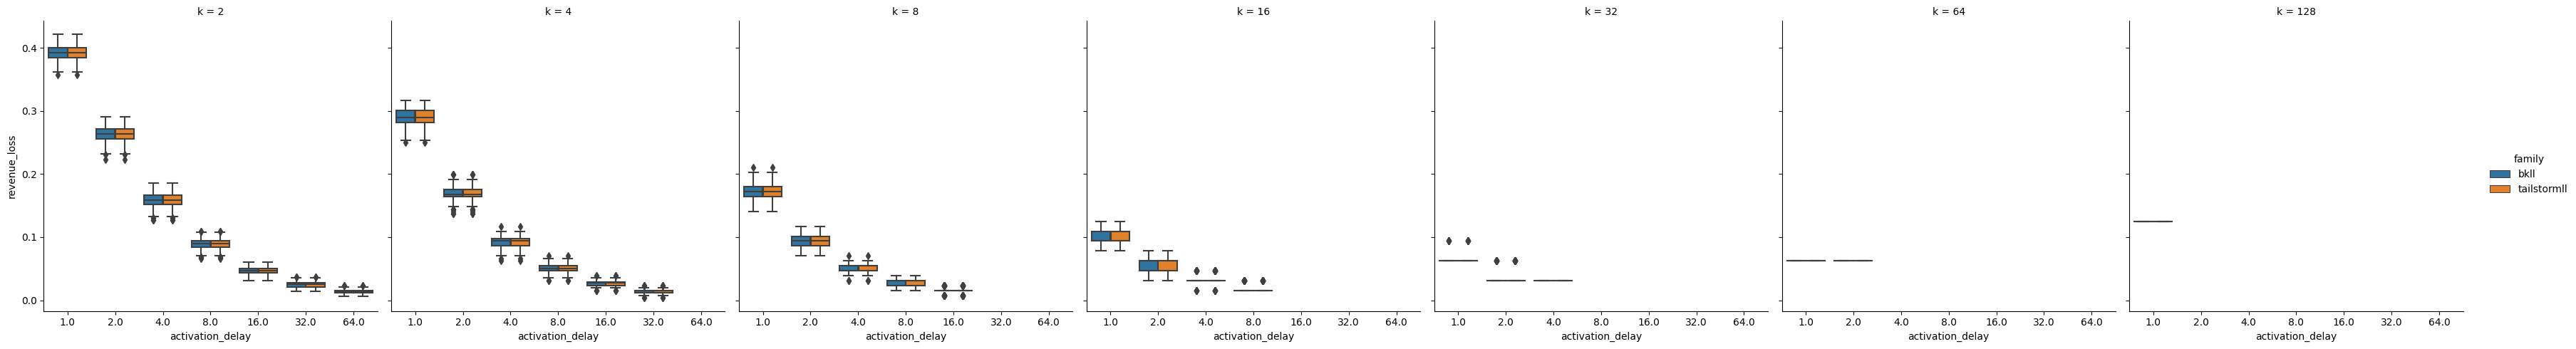

In [10]:
# check: bk_ll = tailstorm_ll constant
ax = sns.catplot(
    kind="box",
    data=df.query('family in ["bkll", "tailstormll"] and scheme == "constant"'),
    y="revenue_loss",
    x="activation_delay",
    hue="family",
    col="k",
)

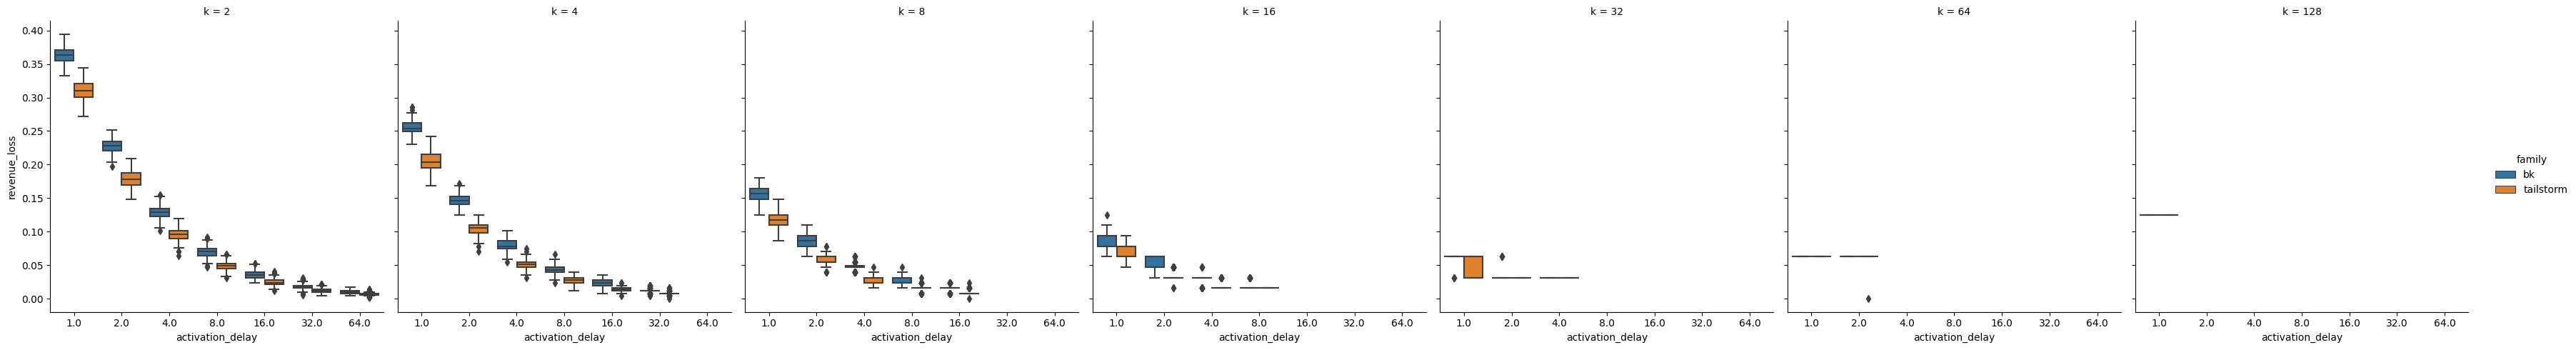

In [11]:
# check: bk != tailstorm constant
ax = sns.catplot(
    kind="box",
    data=df.query('family in ["bk", "tailstorm"] and scheme == "constant"'),
    y="revenue_loss",
    x="activation_delay",
    hue="family",
    col="k",
)

In [12]:
df = df.query('not (family == "tailstormll")')  # redundant with bkll
df = df.query('not (family == "bkll" and k == 2)')  # redundant with nakamoto

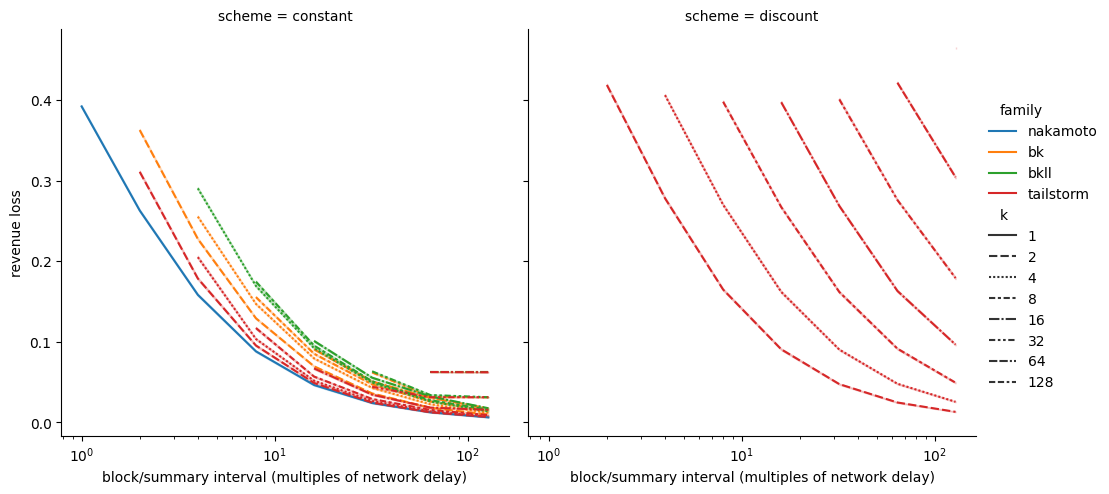

In [13]:
ax = sns.relplot(
    kind="line",
    data=df,
    hue="family",
    style="k",
    y="revenue_loss",
    x="block_interval",
    col="scheme",
)

ax.set(
    xscale="log",
    xlabel="block/summary interval (multiples of network delay)",
    ylabel="revenue loss",
)

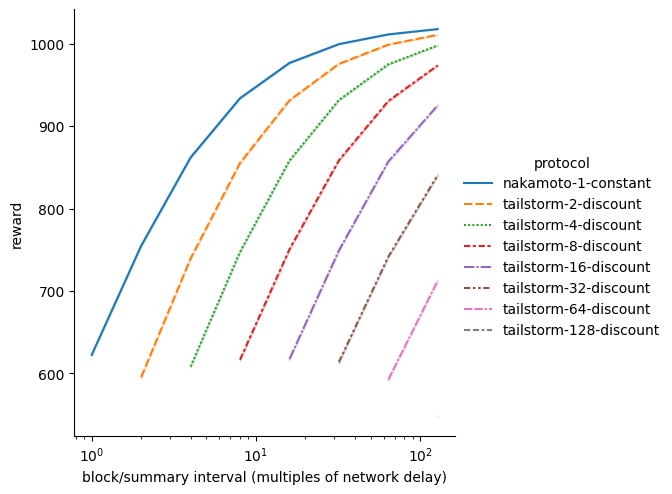

In [14]:
ax = sns.relplot(
    kind="line",
    data=df.query(
        "family == 'nakamoto' or (family == 'tailstorm' and scheme == 'discount')"
    ),
    hue="protocol",
    style="protocol",
    y="reward",
    x="block_interval",
)

ax.set(
    xscale="log",
    xlabel="block/summary interval (multiples of network delay)",
    ylabel="reward",
)

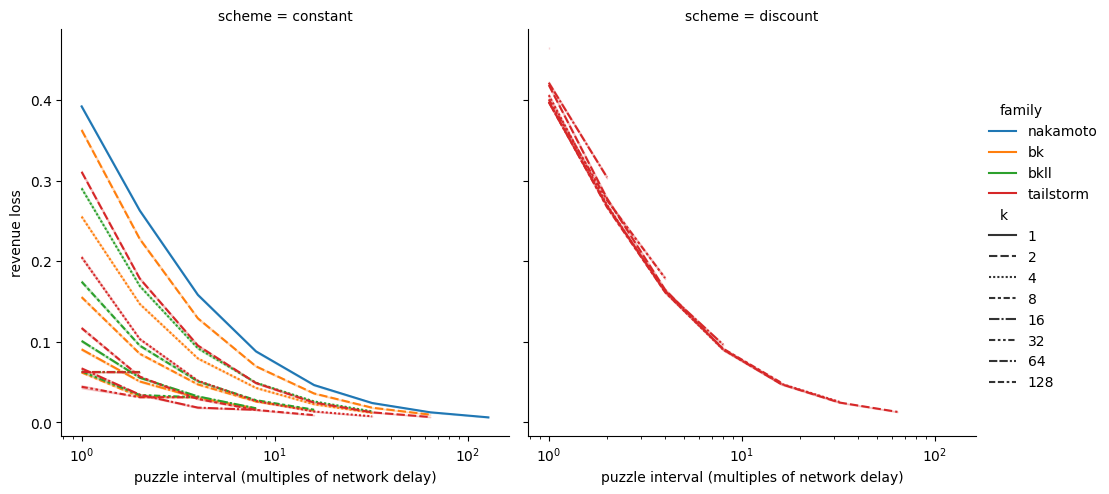

In [15]:
ax = sns.relplot(
    kind="line",
    data=df,
    hue="family",
    style="k",
    y="revenue_loss",
    x="activation_delay",
    col="scheme",
)

ax.set(
    xscale="log",
    xlabel="puzzle interval (multiples of network delay)",
    ylabel="revenue loss",
)

In [16]:
key = ["family", "k", "activation_delay", "block_interval"]
a = (
    df.query('scheme == "constant" and k in [1, 8]')
    .groupby(key)
    .agg(
        orphan_rate=("revenue_loss", np.mean),
        gini_constant=("gini_efficiency1", np.mean),
    )
)
b = (
    df.query('scheme != "constant" and k in [1, 8]')
    .groupby(key)
    .agg(
        revenue_loss=("revenue_loss", np.mean),
        gini_discount=("gini_efficiency1", np.mean),
    )
)
c = a.join(b)
for i, x in c.iterrows():
    if np.isnan(x.revenue_loss):
        c.loc[i]["revenue_loss"] = c.loc[i].orphan_rate
c.reset_index().sort_values(["block_interval", "family"])

,family,k,activation_delay,block_interval,orphan_rate,gini_constant,revenue_loss,gini_discount
10,nakamoto,1,1.0,1,0.391979,0.112057,0.391979,NaN
11,nakamoto,1,2.0,2,0.262886,0.056366,0.262886,NaN
12,nakamoto,1,4.0,4,0.158291,0.031197,0.158291,NaN
0,bk,8,1.0,8,0.155396,0.025437,0.155396,NaN
5,bkll,8,1.0,8,0.174530,0.031479,0.174530,NaN
13,nakamoto,1,8.0,8,0.088181,0.018779,0.088181,NaN
18,tailstorm,8,1.0,8,0.117035,0.022088,0.397770,0.032382
1,bk,8,2.0,16,0.085236,0.015376,0.085236,NaN
6,bkll,8,2.0,16,0.095306,0.018850,0.095306,NaN
14,nakamoto,1,16.0,16,0.046402,0.011525,0.046402,NaN


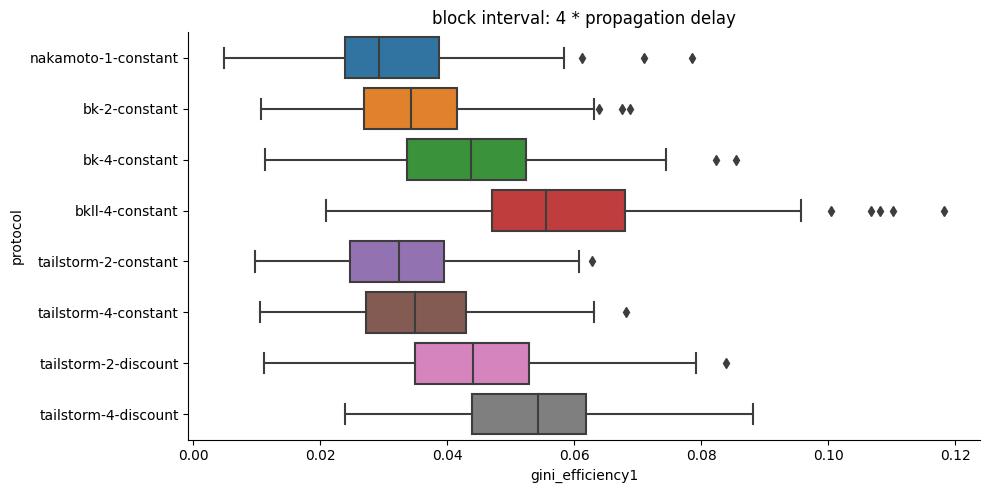

In [17]:
def bp_bi(metric, bi=32):
    plt = sns.catplot(
        data=df.query(f"block_interval == {bi}"),
        x=metric,
        y="protocol",
        kind="box",
        aspect=2,
        row="block_interval",
    )
    plt.set(title=f"block interval: {bi} * propagation delay")


def bp_ad(metric, ad=4):
    plt = sns.catplot(
        data=df.query(f"activation_delay == {ad}"),
        x=metric,
        y="protocol",
        kind="box",
        aspect=2,
    )
    plt.set(title=f"activation delay: {ad} * propagation delay")


bp_bi("gini_efficiency1", bi=4)

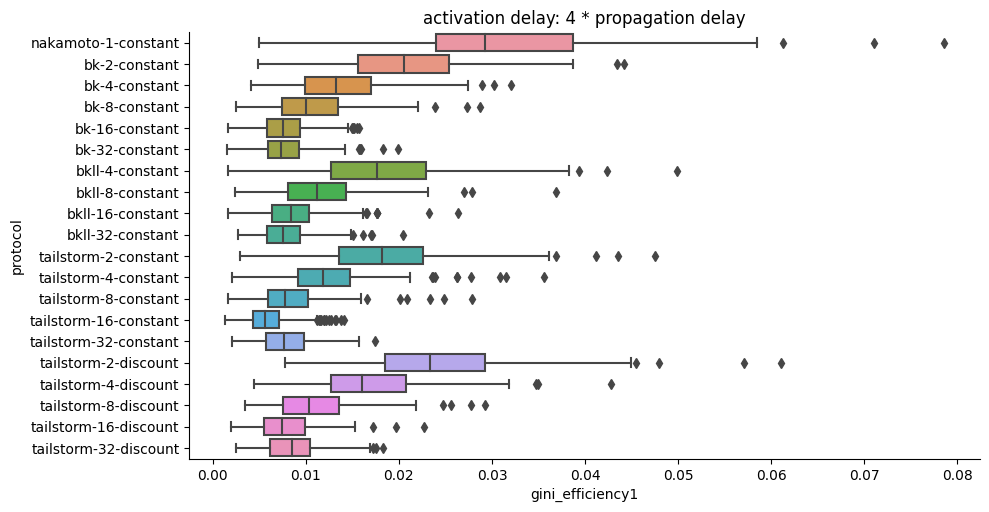

In [18]:
bp_ad("gini_efficiency1", ad=4)

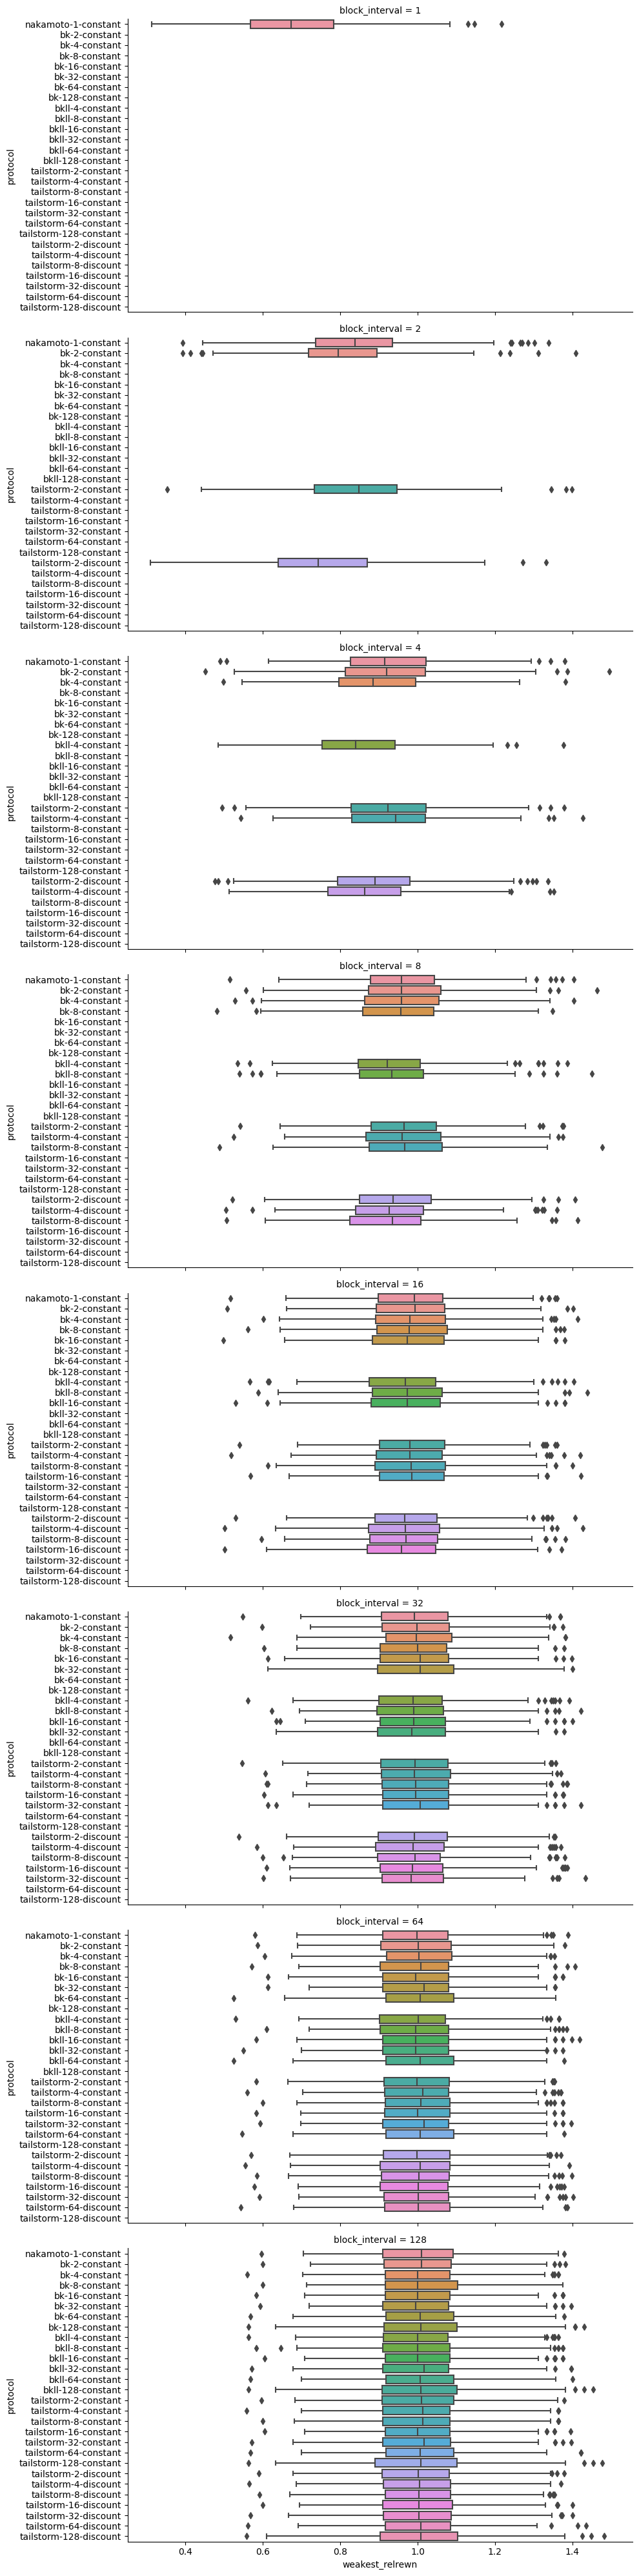

In [19]:
plt = sns.catplot(
    data=df,
    # x="gini_efficiency1",
    x="weakest_relrewn",
    # x="strongest_relrewn",
    y="protocol",
    kind="box",
    aspect=2,
    row="block_interval",
)

# Draft table for paper

In [36]:
def rows():
    def r(f, k, s, ad, i):
        return pd.Series(
            dict(
                family=f,
                k=k,
                scheme=s,
                protocol=f"{f}-{k}-{s}",
                block_interval=ad * k,
                activation_delay=ad,
                seed=i,
                activations=int(3600 / 6 / ad),  # one hour, propagation delay = 6s
            )
        )

    for i in range(256):
        for ad in [1, 2, 4, 8, 16, 32, 64]:
            yield r("nakamoto", 1, "constant", ad, i)
        for k in [2, 4, 8, 16, 32, 64]:
            bi = 64
            yield r("bk", k, "constant", bi / k, i)
            yield r("tailstorm", k, "constant", bi / k, i)
            yield r("tailstorm", k, "discount", bi / k, i)


df2 = pd.DataFrame(rows())
df2 = parallel_measure(df2, n_jobs=6)

  0%|          | 0/6400 [00:00<?, ?it/s]

,family,k,scheme,protocol,block_interval,activation_delay,seed,activations,chain_time,progress,...,diff_reward,diff_relrew,diff_relrewn,diff_efficiency0,diff_efficiency1,gini_reward,gini_relrew,gini_relrewn,gini_efficiency0,gini_efficiency1
0,nakamoto,1,constant,nakamoto-1-constant,1.0,1.0,0,600,655.596478,373.0,...,117.00000,0.313673,6.286863e-01,234.500000,0.241324,0.339142,0.339142,0.103094,0.103094,0.068893
1,nakamoto,1,constant,nakamoto-1-constant,2.0,2.0,0,300,643.739224,218.0,...,66.00000,0.302752,4.977064e-01,108.500000,0.202717,0.339450,0.339450,0.096339,0.096339,0.046003
2,nakamoto,1,constant,nakamoto-1-constant,4.0,4.0,0,150,607.818895,126.0,...,32.00000,0.253968,1.944444e-01,24.500000,0.047619,0.291005,0.291005,0.060837,0.060837,0.050371
3,nakamoto,1,constant,nakamoto-1-constant,8.0,8.0,0,75,610.618734,70.0,...,18.00000,0.257143,1.500000e-01,10.500000,0.000000,0.271429,0.271429,0.109524,0.109524,0.030596
4,nakamoto,1,constant,nakamoto-1-constant,16.0,16.0,0,37,615.068312,35.0,...,13.00000,0.371429,3.000000e-01,10.500000,0.000000,0.395238,0.395238,0.187943,0.187943,0.074359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6395,tailstorm,32,constant,tailstorm-32-constant,64.0,2.0,255,300,560.082963,288.0,...,72.00000,0.250000,2.430556e-02,7.000000,-0.044444,0.290509,0.290509,0.024973,0.024973,0.014846
6396,tailstorm,32,discount,tailstorm-32-discount,64.0,2.0,255,300,560.082963,288.0,...,53.96875,0.252190,4.446554e-02,9.515625,-0.018601,0.292884,0.292884,0.025151,0.025151,0.015322
6397,bk,64,constant,bk-64-constant,64.0,1.0,255,600,580.735012,576.0,...,140.00000,0.243056,3.038194e-02,17.500000,0.001032,0.280093,0.280093,0.022546,0.022546,0.016176
6398,tailstorm,64,constant,tailstorm-64-constant,64.0,1.0,255,600,578.944617,576.0,...,135.00000,0.234375,1.110223e-16,0.000000,-0.027870,0.269676,0.269676,0.031339,0.031339,0.011195


- plot some curves for gini and normalized reward of weakest miner
- tex the table, maybe reduce columns

In [37]:
(
    df2
    # .assign(family = pd.Categorical(df2.family, categories=['nakamoto', 'bk', 'tailstorm']))
    .groupby(
        ["family", "k", "scheme", "block_interval", "activation_delay", "activations"]
    )
    .agg(
        chain_time_mean=("chain_time", np.mean),
        progress_mean=("progress", np.mean),
        height_mean=("height", np.mean),
        reward_mean=("reward", np.mean),
        weakest_nrr_mean=("weakest_relrewn", np.mean),
        weakest_nrr_std=("weakest_relrewn", np.std),
        strongest_nrr_mean=("strongest_relrewn", np.mean),
        strongest_nrr_std=("strongest_relrewn", np.std),
        rr_gini_mean=("gini_relrewn", np.mean),
        rr_gini_std=("gini_relrewn", np.std),
        nobs=("weakest_relrewn", len),
    )
    .query("nobs > 0")
    .sort_values(["k", "family", "scheme", "block_interval"])
    .reset_index()
)

,family,k,scheme,block_interval,activation_delay,activations,chain_time_mean,progress_mean,height_mean,reward_mean,weakest_nrr_mean,weakest_nrr_std,strongest_nrr_mean,strongest_nrr_std,rr_gini_mean,rr_gini_std,nobs
0,nakamoto,1,constant,1.0,1.0,600,599.637728,364.921875,364.921875,364.921875,0.686170,0.222006,1.169801,0.119979,0.133138,0.038892,256
1,nakamoto,1,constant,2.0,2.0,300,601.061582,221.230469,221.230469,221.230469,0.843368,0.292403,1.082513,0.125850,0.112937,0.040289,256
2,nakamoto,1,constant,4.0,4.0,150,600.772035,126.085938,126.085938,126.085938,0.909703,0.402269,1.031697,0.162265,0.136412,0.049688,256
3,nakamoto,1,constant,8.0,8.0,75,599.060213,68.390625,68.390625,68.390625,0.951122,0.493148,1.029346,0.200114,0.169448,0.053961,256
4,nakamoto,1,constant,16.0,16.0,37,583.537584,35.265625,35.265625,35.265625,0.973014,0.694297,1.016982,0.277836,0.225005,0.077812,256
5,nakamoto,1,constant,32.0,32.0,18,577.658737,17.617188,17.617188,17.617188,0.966447,1.055540,1.023648,0.363167,0.327647,0.106436,256
6,nakamoto,1,constant,64.0,64.0,9,583.599887,8.878906,8.878906,8.878906,0.912598,1.376637,0.997016,0.510874,0.449988,0.100301,256
7,bk,2,constant,64.0,32.0,18,572.548024,17.484375,8.742188,17.484375,0.941650,1.027938,1.028049,0.357825,0.325155,0.104500,256
8,tailstorm,2,constant,64.0,32.0,18,574.287628,17.703125,8.851562,17.703125,0.967285,1.041878,1.025106,0.357441,0.321879,0.105402,256
9,tailstorm,2,discount,64.0,32.0,18,574.287628,17.703125,8.851562,17.492188,0.969735,1.053767,1.026284,0.362510,0.324207,0.104838,256


{0: array([0.76989532, 0.67992271]),
 1: array([-0.20449017,  1.        ]),
 2: array([-0.97551401,  0.32595123]),
 3: array([ 0.20205842, -0.99221377]),
 4: array([-0.77445644, -0.68698591]),
 5: array([ 0.98250687, -0.32667425])}

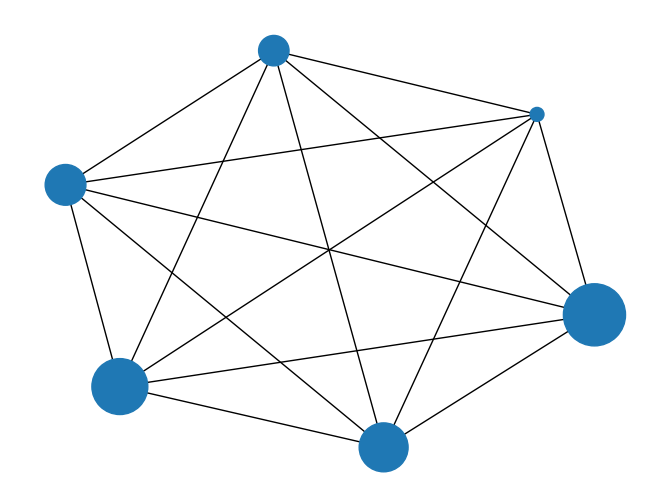

In [23]:
draw(G)